# Categorical Embedding

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate, Conv1D, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
	raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data

In [3]:
data = pd.read_csv("./splited_full_RASFF_DATA.csv", sep=";", header=0, index_col=0)
data = data.sample(frac=1)

data.head(1)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
131832,2008-08-19,Germany,ices and desserts,food,undecided,recall from consumers,distribution on the market (possible),food additives and flavourings,Vietnam,Germany,


In [4]:
class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.y_train = None, None
		self.x_val, self.y_val = None, None
		self.x_test, self.y_test = None, None

		self.input_list_train, self.input_list_test, self.input_list_testval = None, None, None

		self.__transform()

	def __transform(self):
		strategy = OneHotEncoder(handle_unknown="ignore", sparse=False)
		strategy.fit(self.y.values)

		self.y = strategy.transform(self.y.values)

		self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2)
		self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=42,shuffle = True)

	def get_metrics(self):
		result = model.predict(self.input_list_test, batch_size=64)
		result = np.argmax(result, axis=-1)

		print(f"- Accuracy: {round(accuracy_score(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")

		print(classification_report(np.argmax(self.y_test, axis=-1), result, zero_division=True))

		cm = confusion_matrix(np.argmax(self.y_test, axis=-1), result)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

		plt.show()

## Preprocessing

In [5]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)

data = data.dropna(subset=['DATE_CASE'])

In [6]:
def preproc(X_train, X_test, X_val):
    input_list_train = []
    input_list_test = []
    input_list_testval = []
    
    for c in stage1.x.columns:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        input_list_testval.append(X_val[c].map(val_map).fillna(0).values)

    return input_list_train, input_list_test,input_list_testval

In [7]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

## Data Mining

In [8]:
stage1 = Stage(
	input=[0, 1, 6, 8, 2, 7],
	output=[5]
)

In [9]:
def top_1_categorical_accuracy(y_true, y_pred):
	return top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [10]:
input_models = []
output_embeddings = []

for categorical_var in stage1.x.columns:
    cat_emb_name = categorical_var.replace(" ", "") + "_Embedding"
    input_name = "Input_" + categorical_var.replace(" ", "")
    no_of_unique_cat = stage1.x_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
   
    input_model = Input(shape=(1, ), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size, ))(output_model)    
    
    input_models.append(input_model)
    output_embeddings.append(output_model)
  
output = Concatenate()(output_embeddings)
output = Dense(2048,activation="relu")(output)
output = Dropout(0.3)(output)
output = Dense(1024,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(512,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(26, activation="softmax")(output)

model = Model(inputs=input_models, outputs=output)

In [11]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) [(None, 1)]          0                                            
______________________________________________________________________________________________

In [12]:
stage1.input_list_train, stage1.input_list_test, stage1.input_list_testval = preproc(stage1.x_train, stage1.x_test, stage1.x_val)

hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1577/1577 [==============================] - 37s 21ms/step - loss: 1.3827 - accuracy: 0.5929 - top_1_categorical_accuracy: 0.5929 - top_2_categorical_accuracy: 0.7206 - top_3_categorical_accuracy: 0.7895 - val_loss: 1.0095 - val_accuracy: 0.7000 - val_top_1_categorical_accuracy: 0.7000 - val_top_2_categorical_accuracy: 0.8091 - val_top_3_categorical_accuracy: 0.8654
Epoch 2/5
1577/1577 [==============================] - 23s 14ms/step - loss: 0.8403 - accuracy: 0.7499 - top_1_categorical_accuracy: 0.7499 - top_2_categorical_accuracy: 0.8487 - top_3_categorical_accuracy: 0.8974 - val_loss: 0.8308 - val_accuracy: 0.7581 - val_top_1_categorical_accuracy: 0.7581 - val_top_2_categorical_accuracy: 0.8492 - val_top_3_categorical_accuracy: 0.8951
Epoch 3/5
1577/1577 [==============================] - 23s 14ms/step - loss: 0.6062 - accuracy: 0.8177 - top_1_categorical_accuracy: 0.8177 - top_2_categorical_accuracy: 0.8996 - top_3_categorical_accuracy: 0.9338 - val_loss: 0.7530 - val_acc

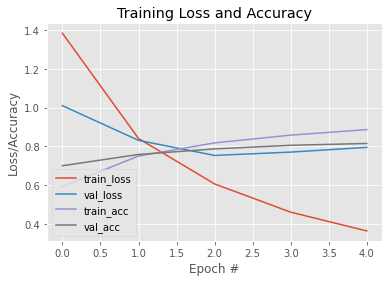

In [13]:
plt.style.use("ggplot")

plt.figure()

plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

- Accuracy: 81.59%
- Specifity: 99.07%
- Sensitivity: 64.01%
- Precision: 73.78%
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1923
           1       0.79      0.77      0.78      2310
           2       0.88      0.32      0.47        22
           4       0.76      0.74      0.75      2775
           5       0.88      0.76      0.81       502
           6       1.00      0.00      0.00         1
           7       0.72      0.73      0.72      1265
           8       0.72      0.78      0.75      1006
           9       0.76      0.68      0.72       166
          10       0.85      0.85      0.85      1379
          11       0.73      0.73      0.73       595
          12       0.80      0.67      0.73       472
          13       0.76      0.67      0.71      1771
          14       0.72      0.78      0.75       489
          15       0.57      0.46      0.51       211
          16       0.92      0.82      0.87       752


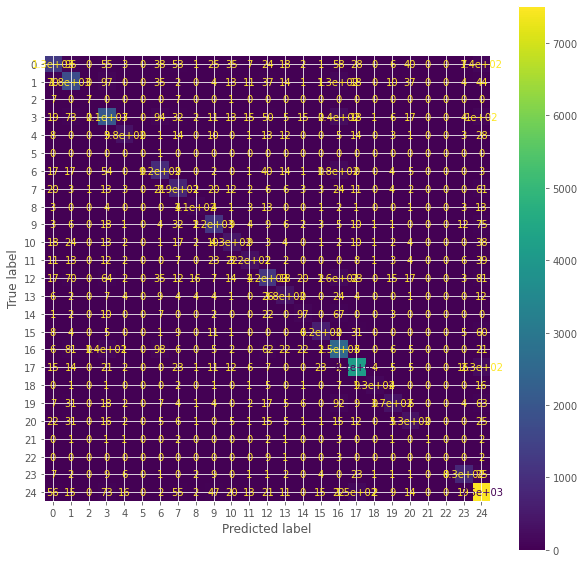

In [14]:
stage1.get_metrics()

1052/1052 [==============================] - 7s 6ms/step - loss: 1.4589 - accuracy: 0.8340 - top_1_categorical_accuracy: 0.8340 - top_2_categorical_accuracy: 0.8866 - top_3_categorical_accuracy: 0.9143
- Accuracy: 83.4%
- Specifity: 99.18%
- Sensitivity: 72.61%
- Precision: 72.18%
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1923
           1       0.80      0.79      0.79      2310
           2       0.49      0.86      0.62        22
           4       0.77      0.79      0.78      2775
           5       0.79      0.83      0.81       502
           6       1.00      0.00      0.00         1
           7       0.69      0.76      0.72      1265
           8       0.78      0.82      0.80      1006
           9       0.70      0.70      0.70       166
          10       0.87      0.89      0.88      1379
          11       0.80      0.74      0.77       595
          12       0.69      0.76      0.72       472
          13   

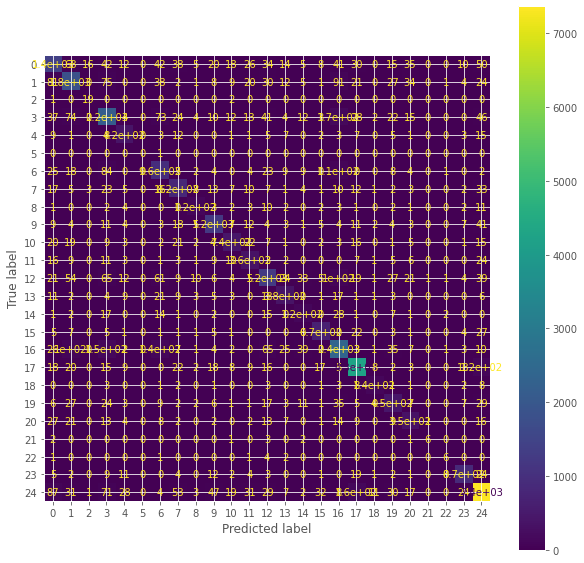



-----------------------

1052/1052 [==============================] - 7s 7ms/step - loss: 1.8192 - accuracy: 0.8393 - top_1_categorical_accuracy: 0.8393 - top_2_categorical_accuracy: 0.8877 - top_3_categorical_accuracy: 0.9122
- Accuracy: 83.93%
- Specifity: 99.24%
- Sensitivity: 70.1%
- Precision: 70.37%
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1923
           1       0.80      0.80      0.80      2310
           2       0.76      0.73      0.74        22
           3       0.00      1.00      0.00         0
           4       0.80      0.78      0.79      2775
           5       0.85      0.83      0.84       502
           6       1.00      0.00      0.00         1
           7       0.70      0.75      0.72      1265
           8       0.81      0.80      0.80      1006
           9       0.82      0.69      0.75       166
          10       0.88      0.89      0.88      1379
          11       0.82      0.75      0.7

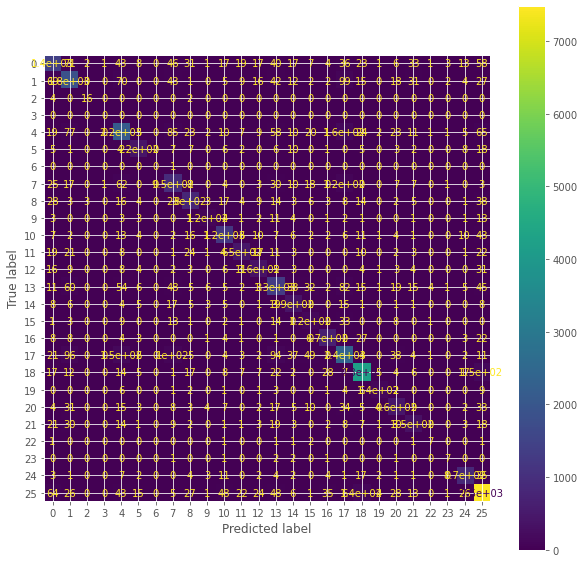



-----------------------

1052/1052 [==============================] - 8s 7ms/step - loss: 2.0718 - accuracy: 0.8375 - top_1_categorical_accuracy: 0.8375 - top_2_categorical_accuracy: 0.8857 - top_3_categorical_accuracy: 0.9114
- Accuracy: 83.75%
- Specifity: 99.23%
- Sensitivity: 68.86%
- Precision: 73.17%
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1923
           1       0.82      0.78      0.80      2310
           2       0.88      0.68      0.77        22
           3       0.00      1.00      0.00         0
           4       0.80      0.78      0.79      2775
           5       0.85      0.83      0.84       502
           6       1.00      0.00      0.00         1
           7       0.69      0.75      0.72      1265
           8       0.84      0.80      0.82      1006
           9       0.79      0.70      0.75       166
          10       0.84      0.90      0.87      1379
          11       0.80      0.76      0.

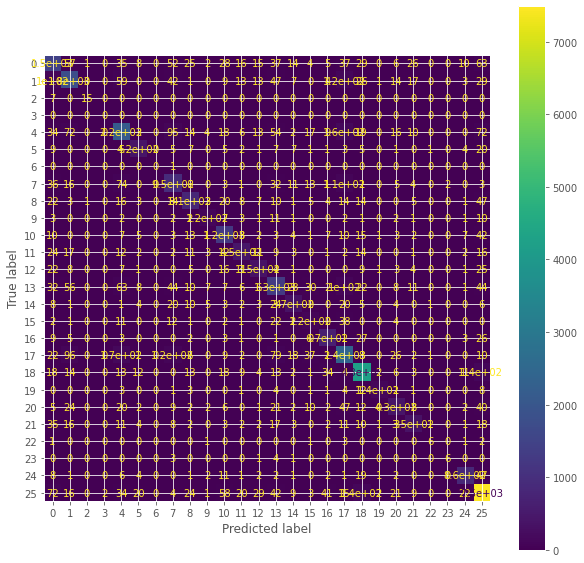



-----------------------

1052/1052 [==============================] - 8s 7ms/step - loss: 2.3434 - accuracy: 0.8362 - top_1_categorical_accuracy: 0.8362 - top_2_categorical_accuracy: 0.8847 - top_3_categorical_accuracy: 0.9098
- Accuracy: 83.62%
- Specifity: 99.22%
- Sensitivity: 68.59%
- Precision: 73.22%
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1923
           1       0.80      0.79      0.80      2310
           2       0.89      0.73      0.80        22
           3       0.00      1.00      0.00         0
           4       0.80      0.76      0.78      2775
           5       0.86      0.83      0.84       502
           6       1.00      0.00      0.00         1
           7       0.67      0.74      0.70      1265
           8       0.83      0.80      0.81      1006
           9       0.82      0.69      0.75       166
          10       0.85      0.89      0.87      1379
          11       0.81      0.75      0.

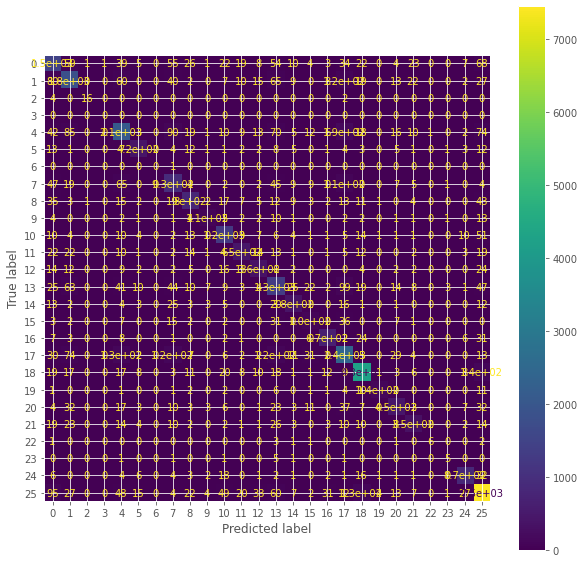



-----------------------

1052/1052 [==============================] - 8s 7ms/step - loss: 2.3568 - accuracy: 0.8339 - top_1_categorical_accuracy: 0.8339 - top_2_categorical_accuracy: 0.8809 - top_3_categorical_accuracy: 0.9057
- Accuracy: 83.39%
- Specifity: 99.21%
- Sensitivity: 68.41%
- Precision: 72.32%
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1923
           1       0.84      0.76      0.80      2310
           2       0.79      0.86      0.83        22
           3       0.00      1.00      0.00         0
           4       0.76      0.79      0.77      2775
           5       0.90      0.82      0.86       502
           6       1.00      0.00      0.00         1
           7       0.74      0.68      0.71      1265
           8       0.85      0.79      0.82      1006
           9       0.87      0.66      0.75       166
          10       0.88      0.89      0.88      1379
          11       0.83      0.74      0.

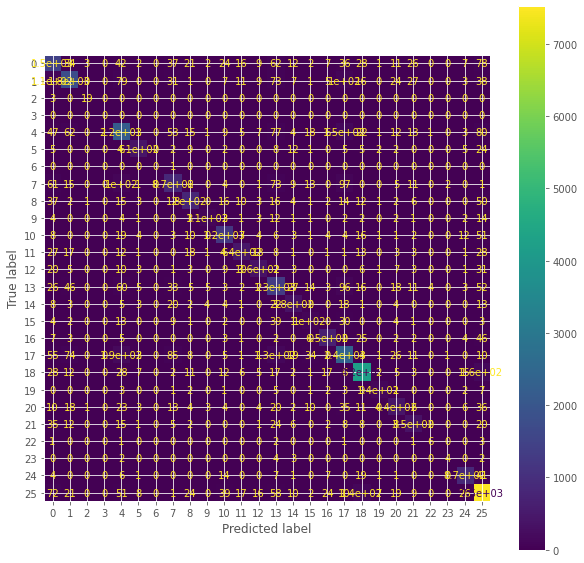



-----------------------



In [15]:
historials = []
evaluations = []

for i in range (1, 6):
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy, top_2_categorical_accuracy, top_3_categorical_accuracy])
    
    hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=25, batch_size=64, verbose=0)
    historials.append(hist)
    
    evaluation = model.evaluate(x=stage1.input_list_test, y=stage1.y_test)
    evaluations.append(evaluation)
    
    model.save("model" + str(i) + ".h5")

    stage1.get_metrics()

    print("\n\n-----------------------\n")

In [20]:
input_models = []
output_embeddings = []

for categorical_var in stage1.x.columns:
	cat_emb_name = categorical_var.replace(" ", "") + "_Embedding"
	input_name = "Input_" + categorical_var.replace(" ", "")
	no_of_unique_cat  = stage1.x_train[categorical_var].nunique()
	embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))

	input_model = Input(shape=(1, ), name=input_name)
	output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
	output_model = Reshape(target_shape=(embedding_size, ))(output_model)    

	input_models.append(input_model)
	output_embeddings.append(output_model)
  
output = Concatenate()(output_embeddings)
output = Reshape(input_shape=(100, ), target_shape=(166, 1))(output)
output = Conv1D(filters=128,kernel_size=4, activation = "relu")(output)
output = Conv1D(filters=128,kernel_size=4, activation = "relu")(output)
output = BatchNormalization()(output)
output = MaxPooling1D(pool_size=2)(output)
output = Conv1D(filters=256,kernel_size=3, activation = "relu")(output)
output = Conv1D(filters=256,kernel_size=3, activation = "relu")(output)
output = BatchNormalization()(output)
output = GlobalMaxPooling1D()(output)
output = Dense(512, activation = "relu")(output)
output = Dense(256, activation = "relu")(output)
output = Dense(26, activation='softmax')(output)

model = Model(inputs=input_models, outputs=output)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) [(None, 1)]          0                                            
____________________________________________________________________________________________

In [22]:
stage1.input_list_train, stage1.input_list_test, stage1.input_list_testval = preproc(stage1.x_train, stage1.x_test, stage1.x_val)

hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val) , epochs =  25, batch_size = 64, verbose= 1)

Epoch 1/25
1577/1577 [==============================] - 56s 33ms/step - loss: 1.5330 - top_1_categorical_accuracy: 0.5432 - top_2_categorical_accuracy: 0.6839 - top_3_categorical_accuracy: 0.7622 - val_loss: 1.3891 - val_top_1_categorical_accuracy: 0.5836 - val_top_2_categorical_accuracy: 0.7311 - val_top_3_categorical_accuracy: 0.8047
Epoch 2/25
1577/1577 [==============================] - 49s 31ms/step - loss: 1.0967 - top_1_categorical_accuracy: 0.6729 - top_2_categorical_accuracy: 0.7908 - top_3_categorical_accuracy: 0.8519 - val_loss: 1.1451 - val_top_1_categorical_accuracy: 0.6635 - val_top_2_categorical_accuracy: 0.7812 - val_top_3_categorical_accuracy: 0.8436
Epoch 3/25
1577/1577 [==============================] - 49s 31ms/step - loss: 0.9232 - top_1_categorical_accuracy: 0.7218 - top_2_categorical_accuracy: 0.8312 - top_3_categorical_accuracy: 0.8841 - val_loss: 1.0604 - val_top_1_categorical_accuracy: 0.6879 - val_top_2_categorical_accuracy: 0.8040 - val_top_3_categorical_acc

1052/1052 [==============================] - 11s 10ms/step - loss: 1.2078 - top_1_categorical_accuracy: 0.8141 - top_2_categorical_accuracy: 0.8773 - top_3_categorical_accuracy: 0.9074
- Accuracy: 81.41%
- Specifity: 99.06%
- Sensitivity: 67.82%
- Precision: 72.39%
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1923
           1       0.80      0.75      0.78      2310
           2       0.72      0.59      0.65        22
           4       0.73      0.76      0.75      2775
           5       0.82      0.80      0.81       502
           6       1.00      0.00      0.00         1
           7       0.69      0.69      0.69      1265
           8       0.84      0.76      0.80      1006
           9       0.81      0.61      0.70       166
          10       0.84      0.88      0.86      1379
          11       0.69      0.73      0.71       595
          12       0.77      0.72      0.75       472
          13       0.72      0.

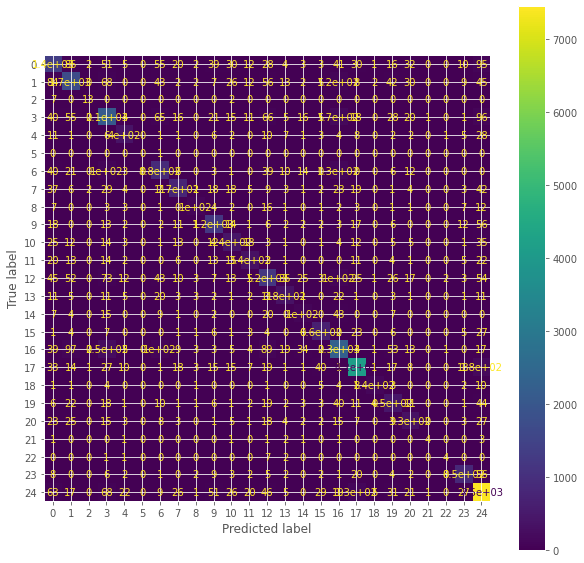

In [23]:
model.evaluate(x=stage1.input_list_test, y=stage1.y_test)

stage1.get_metrics()